In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi

In [2]:
# Exact solution
def exact_solution(x, t):
    return torch.sin(x)*torch.cos(4*pi*t)

# Initial condition
def initial_condition(x):
    return torch.sin(x)

def initial_condition_time(x):
    return 0*np.pi**2*torch.sin(np.pi*x)



In [3]:
# assigning number of points
initial_pts = 2000
left_boundary_pts = 2000
right_boundary_pts = 2000
residual_pts = 10000

# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"
manualSeed = 1

#np.random.seed(manualSeed)
#random.seed(manualSeed)
torch.manual_seed(manualSeed)


In [4]:
# initial points
x_init = pi*torch.rand((initial_pts,1)) # initial pts
t_init =  0*x_init
init =  torch.cat([x_init, t_init],1)
u_init = initial_condition(init[:,0]).reshape(-1, 1)
u_init_t = initial_condition_time(init[:,0]).reshape(-1, 1) #new

In [5]:
#boundary points

xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) # 
b_left = torch.cat([xb_left, tb_left ],1)
u_b_l = 0*xb_left
u_b_l_xx = 0*xb_left #new



In [6]:
xb_right = pi*torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1)
u_b_r = 0*xb_right
u_b_r_xx = 0*xb_right #new


In [7]:
# collocation/ interior points
x_interior = pi*torch.rand((residual_pts, 1))
t_interior = torch.rand((residual_pts, 1))
interior = torch.cat([x_interior, t_interior],1)



In [8]:
# Training set
training_set = DataLoader(torch.utils.data.TensorDataset(init, u_init, u_init_t, b_left, b_right), batch_size=2000, shuffle=False)


In [9]:
# neural network Class

class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)
# Model definition
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = u_init.shape[1], n_hidden_layers=4, neurons=20)


In [10]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)


In [11]:
# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)

if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")
 

In [12]:
def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (initial, u_initial, u_initial_t, bd_left, bd_right) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                
                initial.requires_grad = True
                 # for initial
                u_initial_pred_ = model(initial)
                inputs1 = torch.ones(initial_pts, 1 )
                grad_u_initial = torch.autograd.grad(u_initial_pred_, initial, grad_outputs=inputs1, create_graph=True)[0]
                u_initial_pred_t_ =  grad_u_initial[:, 1]
                
                
                # boundary
                bd_left.requires_grad = True
                bd_right.requires_grad = True
                u_bd_left_pred_ = model(bd_left)
                u_bd_right_pred_ = model(bd_right)
                inputs2 = torch.ones(left_boundary_pts, 1)
                inputs3 = torch.ones(right_boundary_pts, 1)
                grad_u_b_l = torch.autograd.grad(u_bd_left_pred_, bd_left, grad_outputs=inputs2, create_graph=True)[0]
                grad_u_b_r = torch.autograd.grad(u_bd_right_pred_, bd_right, grad_outputs=inputs3, create_graph=True)[0]
                u_b_l_x = grad_u_b_l[:, 0]
                u_b_r_x = grad_u_b_r[:, 0]
                u_b_l_xx = torch.autograd.grad(u_b_l_x, bd_left, grad_outputs=torch.ones(bd_left.shape[0]), create_graph=True)[0]
                u_bd_left_pred_xx_ = u_b_l_xx[:, 0]
                
                u_b_r_xx = torch.autograd.grad(u_b_r_x, bd_right, grad_outputs=torch.ones(bd_right.shape[0]), create_graph=True)[0]
                u_bd_right_pred_xx_ = u_b_r_xx[:, 0]
                
                
                
                
                
                
               
                # residual calculation
                interior.requires_grad = True
                u_hat = model(interior)
                inputs = torch.ones(residual_pts, 1 )
              
                grad_u_hat = torch.autograd.grad(u_hat, interior, grad_outputs=inputs, create_graph=True)[0]
                
                u_x = grad_u_hat[:, 0]
                u_t =  grad_u_hat[:, 1]
                
                grad_grad_u_t = torch.autograd.grad(u_t, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                u_tt = grad_grad_u_t[:, 1]
                
                grad_grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                u_xx = grad_grad_u_x[:, 0]
                
                grad_grad_u_xx = torch.autograd.grad(u_xx, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                u_xxx = grad_grad_u_xx[:, 0]
                
                grad_grad_u_xxx = torch.autograd.grad(u_xxx, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                u_xxxx = grad_grad_u_xxx[:, 0]
                
            
                
                # Item 1. below
                loss_ini = torch.mean((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, ))**p) + torch.mean((u_initial_pred_t_.reshape(-1, ) - u_initial_t.reshape(-1, ))**p)
                
                loss_p = torch.mean((u_tt.reshape(-1, ) + u_xxxx.reshape(-1, )-(1 -16*pi**2)*torch.sin(interior[:, 0])*torch.cos(4*pi*interior[:, 1]))**p)
                
                loss_bd = torch.mean((u_bd_left_pred_.reshape(-1,))**p) + torch.mean((u_bd_right_pred_.reshape(-1,))**p)+torch.mean((u_bd_left_pred_xx_.reshape(-1,))**p) + torch.mean((u_bd_right_pred_xx_.reshape(-1,))**p)
                
                loss = loss_ini + 0.1*loss_p + loss_bd
               
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history
n_epochs = 15000
#history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )


In [13]:
# saving and loading Model
FILE = "first_.pth"
#torch.save(my_network, FILE)

# uncomment below when you need to test for different points
my_network = torch.load(FILE)
my_network.eval()


NeuralNet(
  (activation): Tanh()
  (input_layer): Linear(in_features=2, out_features=20, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
  )
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
)

Relative Error Test:  0.0005351814706955338 %


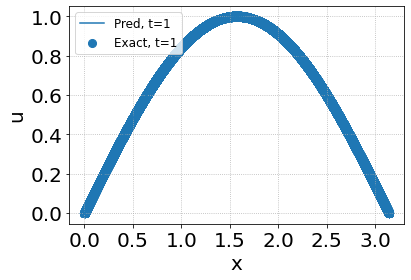

In [14]:
# Compute the relative L2 error norm (generalization error)

x_test = torch.linspace(0, pi, 100000).reshape(-1,1)
t_test = torch.ones(100000).reshape(-1, 1)
test = torch.cat([x_test, t_test],1)


u_test_pred = my_network(test).reshape(-1,1)
u_test = exact_solution(x_test,t_test).reshape(-1,1)

relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

# final time ploting:
# for time t = 1
plt.plot(x_test.detach().numpy(),u_test_pred.detach().numpy(), label='Pred, t=1')
plt.scatter(x_test.detach().numpy(), u_test.detach().numpy(), s = 65,label='Exact, t=1')
plt.grid(linestyle='dotted')
plt.legend(loc='upper left', fontsize = 12)
plt.xlabel('x', fontsize = 20)
plt.ylabel('u', fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(linestyle='dotted')
plt.savefig('first_.png', dpi = 300, bbox_inches = "tight")
plt.savefig('first_.pdf')
# show the plot
plt.show()

In [15]:
# Data taking out for RNN 

In [16]:
import torch

u_sol = torch.zeros(100, 256)
x_test = torch.linspace(0, pi, 256).reshape(-1, 1)
t_test = torch.zeros(256).reshape(-1, 1)
dt = 0.01

# # Assuming my_network is your defined neural network model
# my_network = YourNetworkModel()

for i in range(100):
      # Increment t_test by dt
    test = torch.cat([x_test, t_test], dim=1)
  
  
    output = my_network(test)
    t_test += dt
    u_sol[i, :] = output.reshape(256)  # Reshape output to match u_sol[i, :]

# Rest of your code...
u1 = u_sol.T

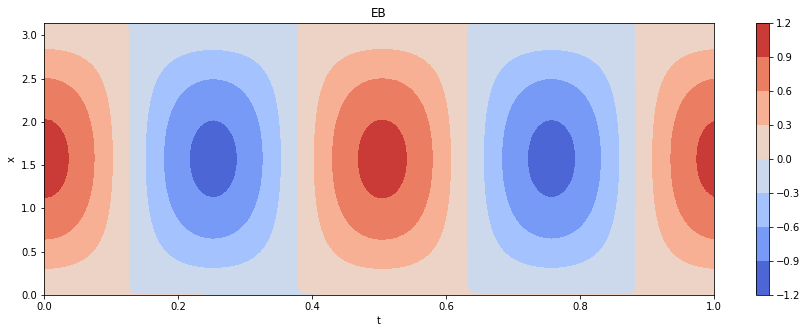

In [17]:
x = np.linspace(0, pi, 256)
t = np.linspace(0, 1, 100)

X, T = np.meshgrid(x, t)
# # Define custom color levels
#c_levels = np.linspace(np.min(u), np.max(u), 100)
u1 = u1.detach().numpy()
# Plot the contour
plt.figure(figsize=(15, 5))
plt.contourf(T, X, u1.T, cmap='coolwarm')
plt.xlabel('t')
plt.ylabel('x')
plt.title('EB')
plt.colorbar()  # Add a colorbar for the contour levels
plt.show()

In [18]:
import numpy as np
import scipy.io

# Example data
data = {
    'x': x,
    't': t,
    'u1': u1,
}

# Save data to .mat file
file_path = 'EB.mat'
scipy.io.savemat(file_path, data)
